In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import decimal
from multiprocessing import Pool
from functools import partial
from matplotlib.ticker import AutoMinorLocator
import random
import pickle

In [2]:
def tRSSA_target_left(tmax, n0,Ag, T,nrep):
    np.random.seed() 
    r  = 0.065+0.081 *math.exp(-0.3*Ag)       # birth rate r for AgNP from chatterjee2015antibacterial
    d  = 0.0037*Ag                            # death rate d for AgNP from chatterjee2015antibacterial
    kr = 0                                    # rate of dissociation of complex AB (kr) is 0 as rxn irreversible
    kf = 4.68*10**5                           # rate of formation of complex AB (kf) taken from terrak1999catalytic
    kD = 0                                    # kD is 0 due to irreversiblity
    beta = kr + kf*A
    dt = 0.1                          
    t = 0
    n = n0                      
    nl = n0-0.1*n0                   
    nu = n0+0.1*n0
    nlist = [n0]
    tlist = np.arange(t,tmax+dt,dt)    
    i = 1
    hl = nl
    hu = nu
    c1l = (1-math.exp(-beta*t))/((kD/A)+1)     # stochastic rate constant for bacteria to undergo death in time time interval dt due to Ampicillin            
    c1u = (1-math.exp(-beta*(t+dt)))/((kD/A)+1)
    c2l = d                                   # stochastic rate constant for bacteria to undergo death in time time interval dt due to AgNP
    c2u = d
    # effective birth rate for bacteria is  r*math.exp(-r*t)
    # l =lower bound , u = upper bound
    c3l = r*math.exp(-r*t)                   # stochastic rate constant bacteria to undergo birth in time time interval dt 
    c3u = r*math.exp(-r*(t+dt))
    a1l = c1l*hl                             # propensity for death to take place due to ampicillin 
    a1u = c1u*hu                
    a2l = c2l*hl                             # propensity for death to take place due to AgNP
    a2u = c2u*hu
    a3l = c3l*hl                             # propensity for birth of bacteria to take place
    a3u = c3u*hu
    a0u = a1u + a2u + a3u                    # total propensity
    update = [-1,-1, 1]                      # update = stoichiometry for reaction , so for birth rate no of bacteria increases by 1 and for death it decreases by 1

    tTotlist = [t]
#
    while n>0:

        greater = True
        j = 0
        while greater == True:
            r1 = np.random.uniform(0,1)
            tau = -math.log(r1)/a0u
            t = t+tau

            if t>tlist[i] and i<tmax/dt:
                j = j+1 
                t = tlist[i]
                i = i+1

                c1l =  (1-math.exp(-beta*tlist[i-1]))/((kD/A)+1)
                c1u =  (1-math.exp(-beta*tlist[i-1]))/((kD/A)+1)
                c2l = d
                c2u = d
                c3u = r*math.exp(-r*tlist[i-1])
                c3l = r*math.exp(-r*tlist[i])
                a1l = c1l*hl
                a1u = c1u*hu
                a2l = c2l*hl
                a2u = c2u*hu
                a3u = c3u*hu
                a3l = c3l*hl
                a0u = a1u+a2u+a3u  
                
            else: 
                greater = False

        rb = np.random.uniform(0,1,2)                  # generating two random numbers to predict which rxn will occur and at what time
        allist = [a1l, a2l,a3l]
        aulist = [a1u, a2u,a3u]
        ausum = np.cumsum(aulist)
        idxlist = np.where(ausum > rb[0]*(a1u+a2u+a3u))
        idx = idxlist[0][0]                           # finding minimum index which satisfies ausum >rb[0]*(a0u)

        accepted = False
        if rb[1] <= allist[idx]/aulist[idx]:
            accepted = True

        else:
            alist = [(((1-math.exp(-beta*t))/((kD/A)+1)))*nlist[-1],d*nlist[-1],(r*math.exp(-r*t))*nlist[-1]]
            if rb[1] <= alist[idx]/aulist[idx]:
                accepted = True

        if accepted:
            n = nlist[-1]+update[idx]                                # updating the state 
 

            if n > hu or n < hl:
                hl = n - 0.1*n                                   
                hu = n + 0.1*n
                c1l = (1-math.exp(-beta*tlist[i-1]))/((kD/A)+1)
                c1u = (1-math.exp(-beta*tlist[i]))/((kD/A)+1)
                c2l = d
                c2u = d
                c3l = r*math.exp(-r*tlist[i-1])
                c3u = r*math.exp(-r*tlist[i])
                a1l = c1l*hl
                a1u = c1u*hu
                a2l = c2l*hl
                a2u = c2u*hu
                a3l = c3l*hl
                a3u = c3u*hu
                a0u = a1u+a2u+a3u


        tTotlist.append(t)
        nlist.append(n)
    return (tTotlist, nlist)

In [30]:
n0s = [10,100,1000]                                 # initial bacterial population list
tmax = 30000 
A = 10**-6                                          # Ampicillin concentration in Molar
kr = 0 
kf = 4.68*10**5
kD = 0
beta = kr + kf*A
Ags  = [0,4,9,49,99]                                # AgNP conc in micromolar
Ts = [10**-6,5*10**-6,10**-5,5*10**-5,10**-4]       # total concentration = Ampicillin concentration + AgNP concentration
for i in range(len(Ts)):
    T = Ts[i]
    Ag = Ags[i]         
    d  = 0.0037*Ag    
    print('T = {}'.format(T))
    for n0 in n0s:
        nreps = list(range(0,1000))
        pool = Pool(processes=3)
        func = partial(tRSSA_target_left,tmax,n0,Ag,T)
        result = pool.map(func,nreps)
        pool.close()
        pool.join()
        trajectory = result
        fname = "/home/rati/Downloads/nafisa/AgNP_AMP with varying AgNP conc/1/traj_dt_0.1_a0u2_added_fraction_target_left_over_n0_{0}_T_{1}.p".format(n0,T)
        pickle_out = open(fname,"wb")
        pickle.dump(trajectory, pickle_out)
        pickle_out.close()

T = 1e-06
T = 4.9999999999999996e-06
T = 1e-05
T = 5e-05
T = 0.0001


[5.01079039992511]
[5.01079039992511, 7.583857515844621]
[5.01079039992511, 7.583857515844621, 9.918109035569218]
[4.837407616169989]
[4.837407616169989, 7.3623484323750565]
[4.837407616169989, 7.3623484323750565, 9.698124258920263]
[4.121670899009536]
[4.121670899009536, 6.3222472248161665]
[4.121670899009536, 6.3222472248161665, 8.413801744857885]
[3.4414770041999416]
[3.4414770041999416, 5.3709872019102916]
[3.4414770041999416, 5.3709872019102916, 7.268029403570213]


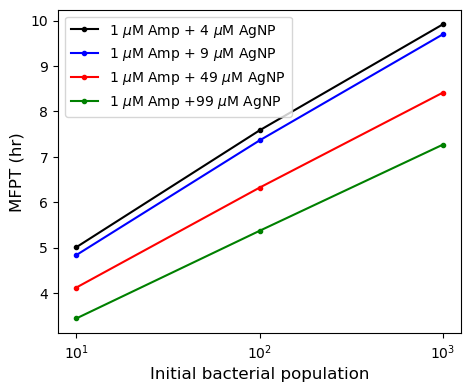

In [32]:
xpos = -0.1
ypos = 1.10
markers_sim = ['ko','bo','ro','go','yo']
markers_calc = ['k.-','b.-','r.-','g.-','y.-']
n0s = [10,100,1000]
A = 10**-6
Ags  = [4,9,49,99] 
Ts = [5*10**-6,10**-5,5*10**-5,10**-4]
kr = 0 
kf = 4.68*10**5 
kD = 0
my=["1 $\mu$M Amp + 4 $\mu$M AgNP","1 $\mu$M Amp + 9 $\mu$M AgNP","1 $\mu$M Amp + 49 $\mu$M AgNP","1 $\mu$M Amp +99 $\mu$M AgNP"]
nreps=1000
j = 0
for T in Ts:
    Tmeans = []
    Tvars = []
    Tstds = []
    Fano = []
    CV = []
    R = []

    for i in range(len(n0s)):
        n0 = n0s[i]
        fname = "/home/rati/Downloads/nafisa/AgNP_AMP with varying AgNP conc/1/traj_dt_0.1_a0u2_added_fraction_target_left_over_n0_{0}_T_{1}.p".format(n0,T)
        with open(fname, 'rb') as fr:
            try:
                while True:
                    data = pickle.load(fr)
                    fptList = []
                    for ni in range(nreps):
                        fpt = data[ni][0][-1]
                        fptList.append(fpt)
                    Tmean = np.mean(fptList)
                    Tvar = np.var(fptList)
                    Tstd = np.std(fptList)
                    Tmeans.append(Tmean)
                    Tvars.append(Tvar)
                    Tstds.append(Tstd)
                    Fano.append(Tvar/Tmean)
                    R.append(Tvar/(Tmean**2))
                    CV.append(Tstd/Tmean)
            except EOFError:
                pass
        fr.close()
        print(Tmeans)
    plt.plot(n0s, Tmeans, markers_calc[j], label='T = {:.0e} M'.format(Ts[j]))
    plt.ylabel('MFPT (hr)',fontsize = 12)
    j = j +1
plt.xlabel('Initial bacterial population',fontsize = 12)
plt.tick_params(which='minor',color='w')
fig = plt.gcf()
fig.set_size_inches(5.2,4.2)
plt.legend( loc="best",bbox_transform=fig.transFigure, ncol=1,labelspacing= 0)
plt.legend(labels=my)
plt.xscale('log')
fig.savefig('ag_amp MFPT wrtN Kconst Agvar birth time dep', dpi=1200)
plt.show()

In [3]:
n0s=[10,100,1000] 
tmax = 30000 
A = 4*10**-6  
kr = 0 
kf = 4.68*10**5
kD = 0
beta = kr + kf*A
Ags  = [4,9,49,99]  
Ts = [8*10**-6,13*10**-6,53*10**-6,103*10**-6]
for i in range(len(Ts)):
    T = Ts[i]
    Ag = Ags[i]         
    d  = 0.0037*Ag    
    print('T = {}'.format(T))
    for n0 in n0s:
        nreps = list(range(0,1000))
        pool = Pool(processes=3)
        func = partial(tRSSA_target_left,tmax,n0,Ag,T)
        result = pool.map(func,nreps)
        pool.close()
        pool.join()
        trajectory = result
        fname = "/home/rati/Downloads/nafisa/AgNP_AMP with varying AgNP conc/4/traj_dt_0.1_a0u2_added_fraction_target_left_over_n0_{0}_T_{1}.p".format(n0,T)
        pickle_out = open(fname,"wb")
        pickle.dump(trajectory, pickle_out)
        pickle_out.close()

T = 8e-06
T = 1.3e-05
T = 5.3e-05
T = 0.000103


[3.5871504136114605]
[3.5871504136114605, 6.003440675488878]
[3.5871504136114605, 6.003440675488878, 8.371000023776885]
[3.4899698880705174]
[3.4899698880705174, 5.81730480099162]
[3.4899698880705174, 5.81730480099162, 8.128720319481769]
[3.105746428490276]
[3.105746428490276, 5.02131862093718]
[3.105746428490276, 5.02131862093718, 7.027219353476048]
[2.567119904983201]
[2.567119904983201, 4.319446168342315]
[2.567119904983201, 4.319446168342315, 6.114022368799433]


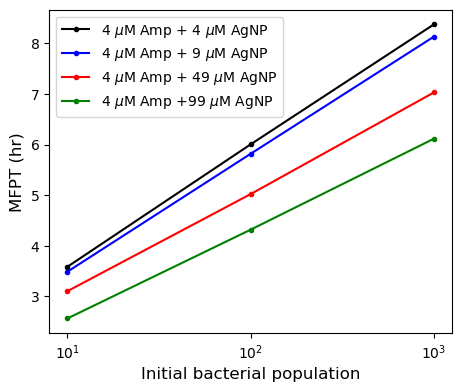

In [4]:
xpos = -0.1
ypos = 1.10
markers_sim = ['ko','bo','ro','go','yo']
markers_calc = ['k.-','b.-','r.-','g.-','y.-']
n0s = [10,100,1000]
A = 4*10**-6
Ags  = [4,9,49,99] 
Ts = [8*10**-6,13*10**-6,53*10**-6,103*10**-6]
kr = 0 
kf = 4.68*10**5 
kD = 0
my=["4 $\mu$M Amp + 4 $\mu$M AgNP","4 $\mu$M Amp + 9 $\mu$M AgNP","4 $\mu$M Amp + 49 $\mu$M AgNP","4 $\mu$M Amp +99 $\mu$M AgNP"]
nreps=1000
j = 0
for T in Ts:
    Tmeans = []
    Tvars = []
    Tstds = []
    Fano = []
    CV = []
    R = []

    for i in range(len(n0s)):
        n0 = n0s[i]
        fname = "/home/rati/Downloads/nafisa/AgNP_AMP with varying AgNP conc/4/traj_dt_0.1_a0u2_added_fraction_target_left_over_n0_{0}_T_{1}.p".format(n0,T)
        with open(fname, 'rb') as fr:
            try:
                while True:
                    data = pickle.load(fr)
                    fptList = []
                    for ni in range(nreps):
                        fpt = data[ni][0][-1]
                        fptList.append(fpt)
                    Tmean = np.mean(fptList)
                    Tvar = np.var(fptList)
                    Tstd = np.std(fptList)
                    Tmeans.append(Tmean)
                    Tvars.append(Tvar)
                    Tstds.append(Tstd)
                    Fano.append(Tvar/Tmean)
                    R.append(Tvar/(Tmean**2))
                    CV.append(Tstd/Tmean)
            except EOFError:
                pass
        fr.close()
        print(Tmeans)
    plt.plot(n0s, Tmeans, markers_calc[j], label='T = {:.0e} M'.format(Ts[j]))
    plt.ylabel('MFPT (hr)',fontsize = 12)
    j = j +1
plt.xlabel('Initial bacterial population',fontsize = 12)
plt.tick_params(which='minor',color='w')
fig = plt.gcf()
fig.set_size_inches(5.2,4.2)
plt.legend( loc="best",bbox_transform=fig.transFigure, ncol=1,labelspacing= 0)
plt.legend(labels=my)
plt.xscale('log')
fig.savefig('ag_amp MFPT ag 4', dpi=1200)
plt.show()

In [33]:
n0s=[10,100,1000] 
tmax = 30000 
A = 9*10**-6  
kr = 0 
kf = 4.68*10**5
kD = 0
beta = kr + kf*A
Ags  = [1,4,9,49,99] 
Ts = [10*10**-6,13*10**-6,18*10**-6,58*10**-6,108*10**-6]
for i in range(len(Ts)):
    T = Ts[i]
    Ag = Ags[i]         
    d  = 0.0037*Ag    
    print('T = {}'.format(T))
    for n0 in n0s:
        nreps = list(range(0,1000))
        pool = Pool(processes=3)
        func = partial(tRSSA_target_left,tmax,n0,Ag,T)
        result = pool.map(func,nreps)
        pool.close()
        pool.join()
        trajectory = result
        fname = "/home/rati/Downloads/nafisa/AgNP_AMP with varying AgNP conc/9/traj_dt_0.1_a0u2_added_fraction_target_left_over_n0_{0}_T_{1}.p".format(n0,T)
        pickle_out = open(fname,"wb")
        pickle.dump(trajectory, pickle_out)
        pickle_out.close()

T = 9.999999999999999e-06
T = 1.3e-05
T = 1.8e-05
T = 5.8e-05
T = 0.000108


[3.341727040863183]
[3.341727040863183, 5.70836118276205]
[3.341727040863183, 5.70836118276205, 8.063373341478988]
[3.1834838828726664]
[3.1834838828726664, 5.4907513750162025]
[3.1834838828726664, 5.4907513750162025, 7.857232226242474]
[2.7668325008187487]
[2.7668325008187487, 4.849978973764875]
[2.7668325008187487, 4.849978973764875, 6.80180797595639]
[2.412459577960634]
[2.412459577960634, 4.123019600917581]
[2.412459577960634, 4.123019600917581, 5.825916835263853]


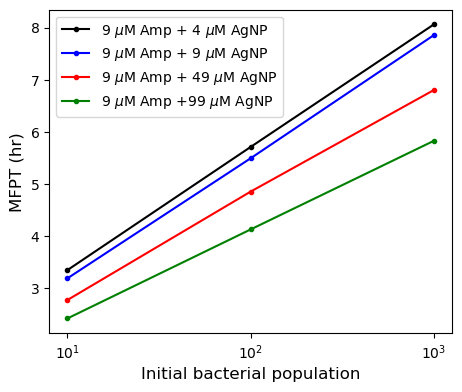

In [7]:
xpos = -0.1
ypos = 1.10
markers_sim = ['ko','bo','ro','go','yo']
markers_calc = ['k.-','b.-','r.-','g.-','y.-']
n0s = [10,100,1000]
A = 9*10**-6
Ags  = [1,4,9,49,99] 
Ts = [13*10**-6,18*10**-6,58*10**-6,108*10**-6]
kr = 0 
kf = 4.68*10**5 
kD = 0
my=["9 $\mu$M Amp + 4 $\mu$M AgNP","9 $\mu$M Amp + 9 $\mu$M AgNP","9 $\mu$M Amp + 49 $\mu$M AgNP","9 $\mu$M Amp +99 $\mu$M AgNP"]
nreps=1000
j = 0
for T in Ts:
    Tmeans = []
    Tvars = []
    Tstds = []
    Fano = []
    CV = []
    R = []

    for i in range(len(n0s)):
        n0 = n0s[i]
        fname = "/home/rati/Downloads/nafisa/AgNP_AMP with varying AgNP conc/9/traj_dt_0.1_a0u2_added_fraction_target_left_over_n0_{0}_T_{1}.p".format(n0,T)
        with open(fname, 'rb') as fr:
            try:
                while True:
                    data = pickle.load(fr)
                    fptList = []
                    for ni in range(nreps):
                        fpt = data[ni][0][-1]
                        fptList.append(fpt)
                    Tmean = np.mean(fptList)
                    Tvar = np.var(fptList)
                    Tstd = np.std(fptList)
                    Tmeans.append(Tmean)
                    Tvars.append(Tvar)
                    Tstds.append(Tstd)
                    Fano.append(Tvar/Tmean)
                    R.append(Tvar/(Tmean**2))
                    CV.append(Tstd/Tmean)
            except EOFError:
                pass
        fr.close()
        print(Tmeans)
    plt.plot(n0s, Tmeans, markers_calc[j], label='T = {:.0e} M'.format(Ts[j]))
    plt.ylabel('MFPT (hr)',fontsize = 12)
    j = j +1
plt.xlabel('Initial bacterial population',fontsize = 12)
plt.tick_params(which='minor',color='w')
fig = plt.gcf()
fig.set_size_inches(5.2,4.2)
plt.legend( loc="best",bbox_transform=fig.transFigure, ncol=1,labelspacing= 0)
plt.legend(labels=my)
plt.xscale('log')
fig.savefig('ag_amp MFPT ag 9', dpi=1200)
plt.show()

In [3]:
n0s=[10,100,1000] 
tmax = 30000 
A = 49*10**-6  
kr = 0 
kf = 4.68*10**5
kD = 0
beta = kr + kf*A
Ags  = [1,4,9,49,99] 
Ts = [50*10**-6,53*10**-6,58*10**-6,108*10**-6,158*10**-6]
for i in range(len(Ts)):
    T = Ts[i]
    Ag = Ags[i]         
    d  = 0.0037*Ag    
    print('T = {}'.format(T))
    for n0 in n0s:
        nreps = list(range(0,1000))
        pool = Pool(processes=3)
        func = partial(tRSSA_target_left,tmax,n0,Ag,T)
        result = pool.map(func,nreps)
        pool.close()
        pool.join()
        trajectory = result
        fname = "/home/rati/Downloads/nafisa/AgNP_AMP with varying AgNP conc/49/traj_dt_0.1_a0u2_added_fraction_target_left_over_n0_{0}_T_{1}.p".format(n0,T)
        pickle_out = open(fname,"wb")
        pickle.dump(trajectory, pickle_out)
        pickle_out.close()

T = 4.9999999999999996e-05
T = 5.3e-05
T = 5.8e-05
T = 0.000108
T = 0.000158


[3.1102814675940587]
[3.1102814675940587, 5.458390867032136]
[3.1102814675940587, 5.458390867032136, 7.792219528855831]
[3.022426302264051]
[3.022426302264051, 5.437817449263899]
[3.022426302264051, 5.437817449263899, 7.620946143809693]
[2.6256712638866486]
[2.6256712638866486, 4.657271121132238]
[2.6256712638866486, 4.657271121132238, 6.636850151050518]
[2.2521203854165694]
[2.2521203854165694, 3.984382462568854]
[2.2521203854165694, 3.984382462568854, 5.727350674001685]


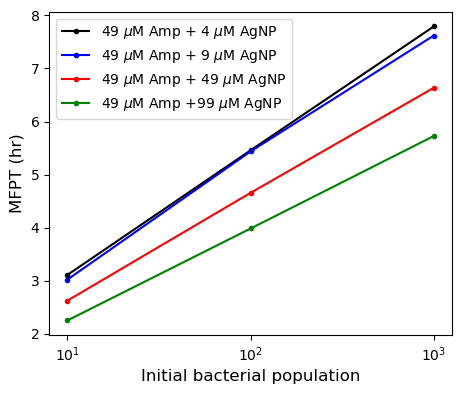

In [8]:
xpos = -0.1
ypos = 1.10
markers_sim = ['ko','bo','ro','go','yo']
markers_calc = ['k.-','b.-','r.-','g.-','y.-']
n0s = [10,100,1000]
A = 49*10**-6
Ags  = [4,9,49,99] 
Ts = [53*10**-6,58*10**-6,108*10**-6,158*10**-6]
kr = 0 
kf = 4.68*10**5 
kD = 0
my=["49 $\mu$M Amp + 4 $\mu$M AgNP","49 $\mu$M Amp + 9 $\mu$M AgNP","49 $\mu$M Amp + 49 $\mu$M AgNP","49 $\mu$M Amp +99 $\mu$M AgNP"]
nreps=1000
j = 0
for T in Ts:
    Tmeans = []
    Tvars = []
    Tstds = []
    Fano = []
    CV = []
    R = []

    for i in range(len(n0s)):
        n0 = n0s[i]
        fname = "/home/rati/Downloads/nafisa/AgNP_AMP with varying AgNP conc/49/traj_dt_0.1_a0u2_added_fraction_target_left_over_n0_{0}_T_{1}.p".format(n0,T)
        with open(fname, 'rb') as fr:
            try:
                while True:
                    data = pickle.load(fr)
                    fptList = []
                    for ni in range(nreps):
                        fpt = data[ni][0][-1]
                        fptList.append(fpt)
                    Tmean = np.mean(fptList)
                    Tvar = np.var(fptList)
                    Tstd = np.std(fptList)
                    Tmeans.append(Tmean)
                    Tvars.append(Tvar)
                    Tstds.append(Tstd)
                    Fano.append(Tvar/Tmean)
                    R.append(Tvar/(Tmean**2))
                    CV.append(Tstd/Tmean)
            except EOFError:
                pass
        fr.close()
        print(Tmeans)
    plt.plot(n0s, Tmeans, markers_calc[j], label='T = {:.0e} M'.format(Ts[j]))
    plt.ylabel('MFPT (hr)',fontsize = 12)
    j = j +1
plt.xlabel('Initial bacterial population',fontsize = 12)
plt.tick_params(which='minor',color='w')
fig = plt.gcf()
fig.set_size_inches(5.2,4.2)
plt.legend( loc="best",bbox_transform=fig.transFigure, ncol=1,labelspacing= 0)
plt.legend(labels=my)
plt.xscale('log')
fig.savefig('ag_amp MFPT ag 49', dpi=1200)
plt.show()